In [1]:
!pip install -q transformers 
!pip install -q peft
!pip install -q evaluate

In [2]:
from datasets import load_dataset

dataset = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Injecting LoRA to the BERT model

In [5]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=1,
    lora_alpha=1,
    lora_dropout=0.1
)

In [6]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased', 
    num_labels=2
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from peft import get_peft_model
model = get_peft_model(model, lora_config)

In [8]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    num_train_epochs=25,
    report_to='tensorboard',
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.677305,0.598000
2,No log,0.670947,0.601000
3,No log,0.666017,0.585000
4,0.689000,0.650490,0.612000
5,0.689000,0.624601,0.675000
6,0.689000,0.596519,0.678000
7,0.689000,0.564959,0.719000
8,0.619600,0.537567,0.727000
9,0.619600,0.510333,0.743000
10,0.619600,0.492861,0.761000


TrainOutput(global_step=3125, training_loss=0.4960851647949219, metrics={'train_runtime': 1525.8657, 'train_samples_per_second': 16.384, 'train_steps_per_second': 2.048, 'total_flos': 6580725657600000.0, 'train_loss': 0.4960851647949219, 'epoch': 25.0})

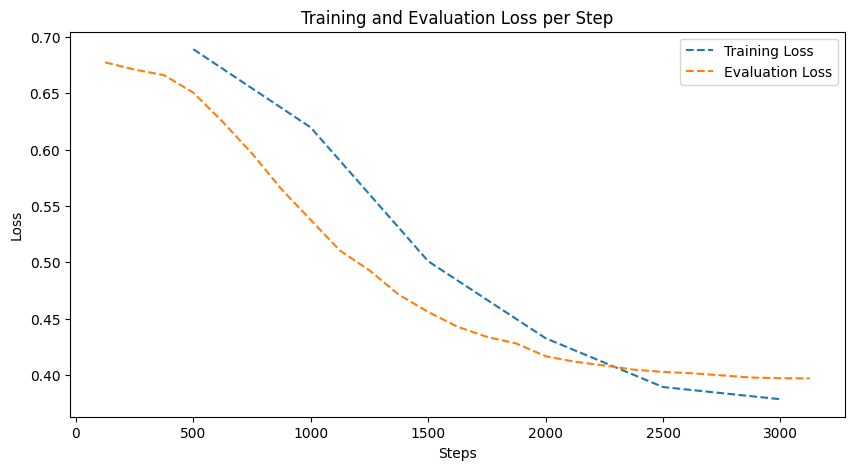

In [31]:
import matplotlib.pyplot as plt

# Extract training loss and evaluation loss from logs
training_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Steps for training loss (logged every `logging_steps`)
train_steps = [log["step"] for log in trainer.state.log_history if "loss" in log]

# Steps for evaluation loss
eval_steps = [log["step"] for log in trainer.state.log_history if "eval_loss" in log]

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(train_steps, training_loss, label="Training Loss", linestyle="--")
plt.plot(eval_steps, eval_loss, label="Evaluation Loss", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Step")
plt.legend()
plt.show()


In [16]:
output_dir = "/kaggle/working/trainer_saved_model"
trainer.save_model(output_dir)

In [17]:
output_dir = "/kaggle/working/saved_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/kaggle/working/saved_model/tokenizer_config.json',
 '/kaggle/working/saved_model/special_tokens_map.json',
 '/kaggle/working/saved_model/vocab.txt',
 '/kaggle/working/saved_model/added_tokens.json',
 '/kaggle/working/saved_model/tokenizer.json')